Download and Visualize Data

In [ ]:
!wget https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip
!mkdir emojis
!unzip -q openmoji-72x72-color.zip -d ./emojis
!pip install tensorflow==2.4

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Check if we are using TensorFlow 2.4')
print('Using TensorFlow version', tf.__version__)

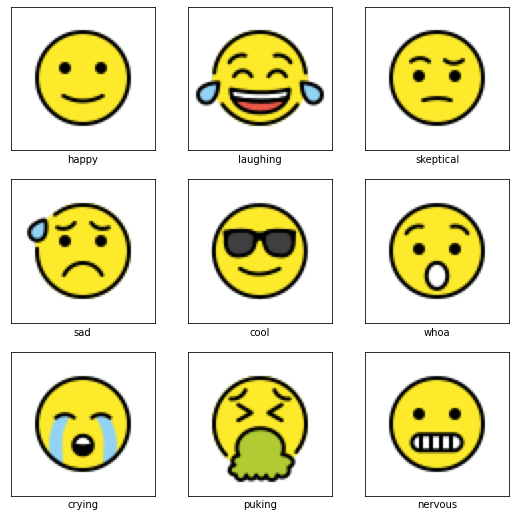

In [ ]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

Create Examples

In [ ]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [ ]:
def create_example():
  class_id = np.random.randint(0, 9)
  image = np.ones((144, 144, 3)) * 255
  row = np.random.randint(0 ,72)
  col = np.random.randint(0, 72)
  image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
  return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144

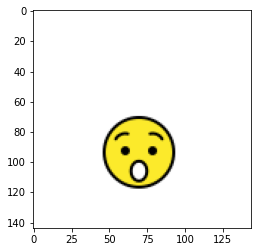

In [ ]:
image, class_id, row, col = create_example()
plt.imshow(image);

Plot Bounding Boxes

In [ ]:
def plot_bb(image, gt_coords, pr_coords=[], norm=False):
  if norm:
    image *= 255.
    image = image.astype('uint8')
  image = Image.fromarray(image)
  draw = ImageDraw.Draw(image)

  row, col = gt_coords
  row *= 144
  col *= 144
  draw.rectangle((col, row, col + 52, row + 52), outline='blue', width=3)

  if len(pr_coords) == 2:
    row, col = pr_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col + 52, row + 52), outline='yellow', width=3)

  return image

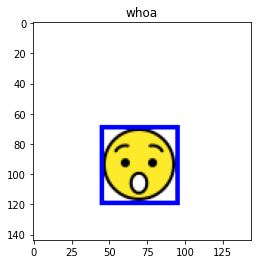

In [ ]:
image = plot_bb(image, gt_coords = [row, col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()


Data Generator

In [ ]:
def data_gen(batch_size=16):
  while True:
    x_batch = np.zeros((batch_size, 144, 144, 3))
    y_batch = np.zeros((batch_size, 9))
    bb_batch = np.zeros((batch_size, 2))

    for i in range(0, batch_size):
      image, class_id, row, col = create_example()
      x_batch[i] = image / 255.
      y_batch[i, class_id] = 1.0
      bb_batch[i] = np.array([row, col])

    yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bb_batch}

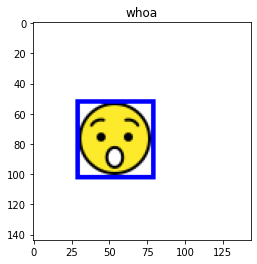

In [ ]:
example, label = next(data_gen(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bb(image, coords, norm=True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

Model

In [ ]:
input_ = Input(shape=(144, 144, 3), name='image')

x = input_

for i in range(0 ,5):
  n_filters = 2**(4 + i)
  x = Conv2D(n_filters, 3, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(2)(x)

x= Flatten()(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(9, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 142, 142, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 142, 142, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 71, 71, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

Custom Metric: IoU

In [ ]:
class IoU(tf.keras.metrics.Metric):
  def __init__(self, **kwargs):
    super(IoU, self).__init__(**kwargs)

    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

  def update_state(self, y_true , y_pred, sample_weight=None):
    def get_box(y):
      rows, cols = y[:, 0], y[:, 1]
      rows, cols = rows * 144, cols *144
      y1, y2 = rows, rows + 52
      x1, x2 = cols, cols + 52
      return x1, y1, x2 , y2

    def get_area(x1, y1, x2, y2):
      return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)

    gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
    p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

    i_x1 = tf.maximum(gt_x1, p_x1)
    i_y1 = tf.maximum(gt_y1, p_y1)
    i_x2 = tf.minimum(gt_x2, p_x2)
    i_y2 = tf.minimum(gt_y2, p_y2)

    i_area = get_area(i_x1, i_y1, i_x2, i_y2)
    u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area
    iou = tf.math.divide(i_area, u_area)
    self.num_ex.assign_add(1)
    self.total_iou.assign_add(tf.reduce_mean(iou))
    self.iou = tf.math.divide(self.total_iou, self.num_ex)

  def result(self):
    return self.iou

  def reset_state(self):
    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

Compile the Model

In [ ]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out': 'accuracy',
        'box_out': IoU(name='iou')
    }
)

Custom Callback: Model Testing

In [ ]:
def test_model(model, test_datagen):
  example, label = next(test_datagen)
  x = example['image']
  y = label['class_out']
  box = label['box_out']

  pred_y, pred_box = model.predict(x)

  pred_coords = pred_box[0]
  gt_coords = box[0]
  pred_class = np.argmax(pred_y[0])
  image = x[0]

  gt = emojis[np.argmax(y[0])]['name']
  pred_class_name = emojis[pred_class]['name']

  image = plot_bb(image, gt_coords, pred_coords, norm=True)
  color = 'blue' if gt == pred_class_name else 'yellow'

  plt.imshow(image)
  plt.xlabel(f'Pred: {pred_class_name}', color=color)
  plt.ylabel(f'GT: {gt}', color=color)
  plt.xticks([])
  plt.yticks([])

In [ ]:
def test(model):
  test_datagen = data_gen(1)

  plt.figure(figsize=(16 ,4))

  for i in range(0, 6):
    plt.subplot(1, 6 , i + 1)
    test_model(model, test_datagen)
  
  plt.show()

In [ ]:
class ShowTestImages(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs=None):
    test(self.model)

Model Training

Epoch 1/50
500/500 [==============================] - 18s 16ms/step - loss: 2.5924 - class_out_loss: 1.5320 - box_out_loss: 1.0604 - class_out_accuracy: 0.4715 - box_out_iou: -0.2512


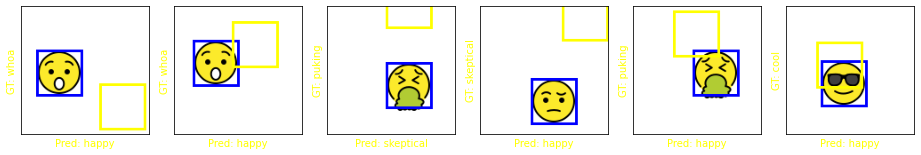

Epoch 2/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0584 - class_out_loss: 0.0151 - box_out_loss: 0.0433 - class_out_accuracy: 0.9997 - box_out_iou: 0.2573


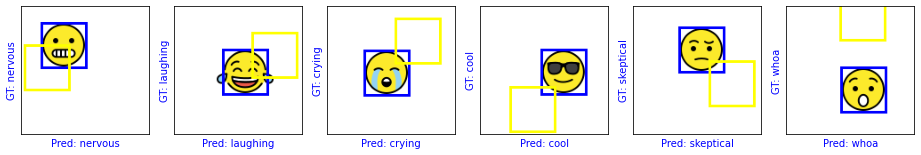

Epoch 3/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0244 - class_out_loss: 0.0055 - box_out_loss: 0.0188 - class_out_accuracy: 0.9992 - box_out_iou: 0.3672


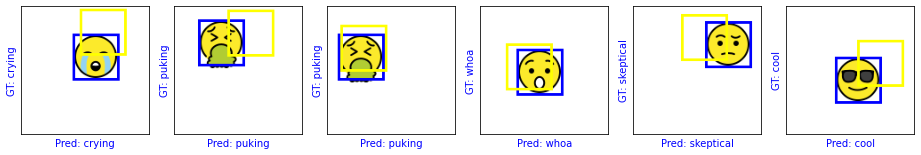

Epoch 4/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0134 - class_out_loss: 0.0026 - box_out_loss: 0.0109 - class_out_accuracy: 0.9997 - box_out_iou: 0.4598


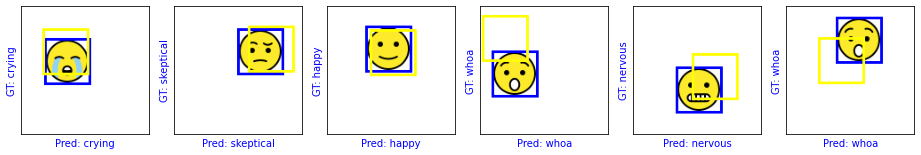

Epoch 5/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0058 - class_out_loss: 0.0014 - box_out_loss: 0.0044 - class_out_accuracy: 1.0000 - box_out_iou: 0.6007


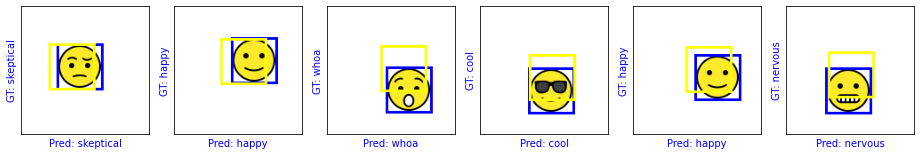

Epoch 6/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0037 - class_out_loss: 7.6674e-04 - box_out_loss: 0.0029 - class_out_accuracy: 1.0000 - box_out_iou: 0.6543


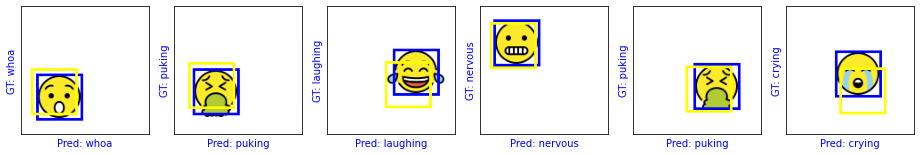

Epoch 7/50
500/500 [==============================] - 8s 17ms/step - loss: 0.0034 - class_out_loss: 6.2205e-04 - box_out_loss: 0.0027 - class_out_accuracy: 1.0000 - box_out_iou: 0.6618


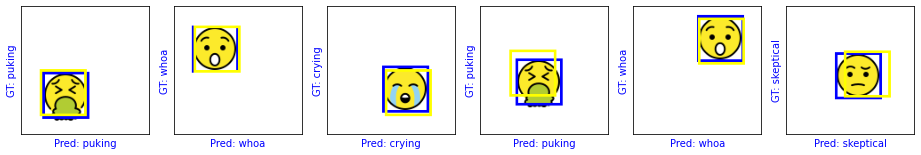

Epoch 8/50
500/500 [==============================] - 8s 17ms/step - loss: 0.0033 - class_out_loss: 7.0392e-04 - box_out_loss: 0.0026 - class_out_accuracy: 1.0000 - box_out_iou: 0.6643


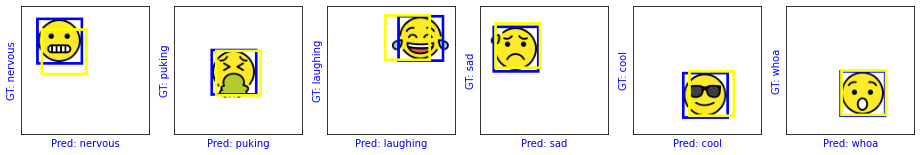

Epoch 9/50
500/500 [==============================] - 8s 17ms/step - loss: 0.0030 - class_out_loss: 4.7164e-04 - box_out_loss: 0.0025 - class_out_accuracy: 1.0000 - box_out_iou: 0.6729


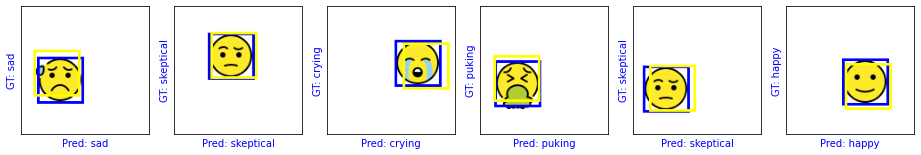

Epoch 10/50
500/500 [==============================] - 8s 17ms/step - loss: 0.0021 - class_out_loss: 4.0038e-04 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - box_out_iou: 0.7158


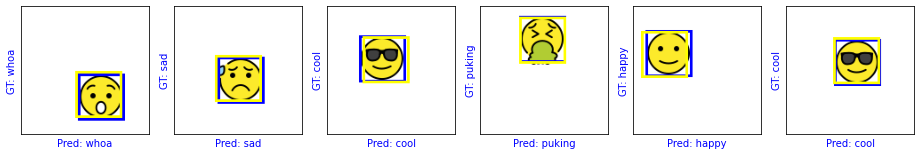

Epoch 11/50
500/500 [==============================] - 9s 17ms/step - loss: 0.0020 - class_out_loss: 3.9474e-04 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - box_out_iou: 0.7204


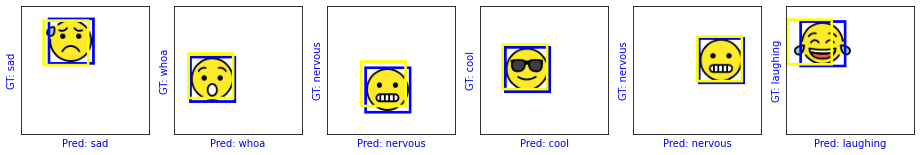

Epoch 12/50
500/500 [==============================] - 8s 17ms/step - loss: 0.0019 - class_out_loss: 3.5460e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7307


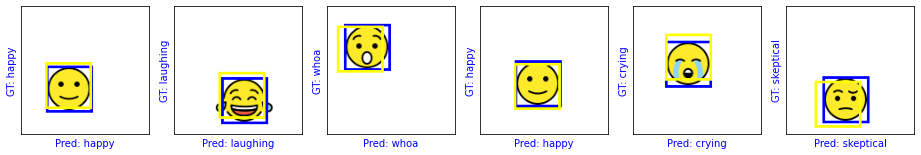

Epoch 13/50
500/500 [==============================] - 9s 17ms/step - loss: 0.0018 - class_out_loss: 3.4692e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7352


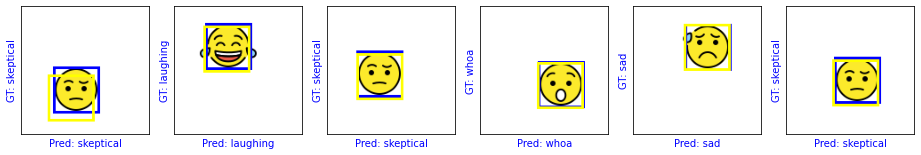

Epoch 14/50
500/500 [==============================] - 9s 17ms/step - loss: 0.0023 - class_out_loss: 7.1743e-04 - box_out_loss: 0.0016 - class_out_accuracy: 0.9998 - box_out_iou: 0.7280


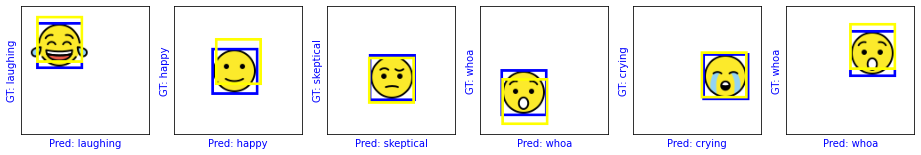

Epoch 15/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0017 - class_out_loss: 3.0209e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7410


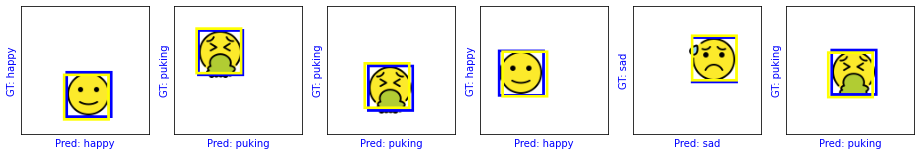

Epoch 16/50
500/500 [==============================] - 9s 17ms/step - loss: 0.0016 - class_out_loss: 3.1670e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7485


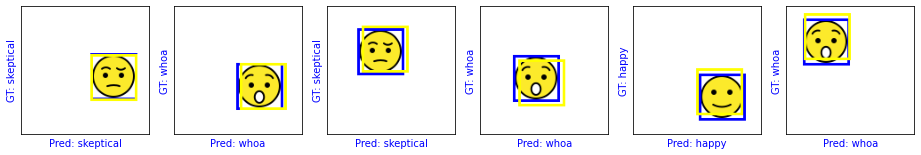

Epoch 17/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0015 - class_out_loss: 2.9530e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7504


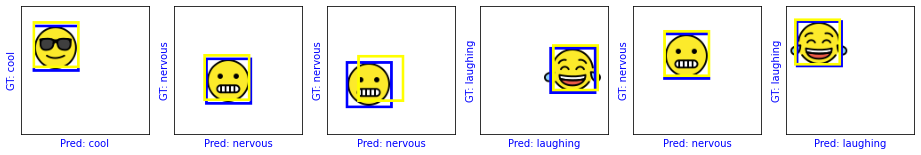

Epoch 18/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0015 - class_out_loss: 2.7704e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7505


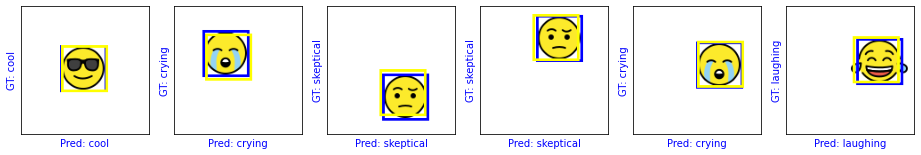

Epoch 19/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0015 - class_out_loss: 2.9626e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7542


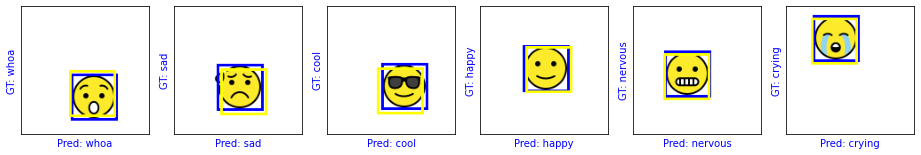

Epoch 20/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0014 - class_out_loss: 2.8114e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7583


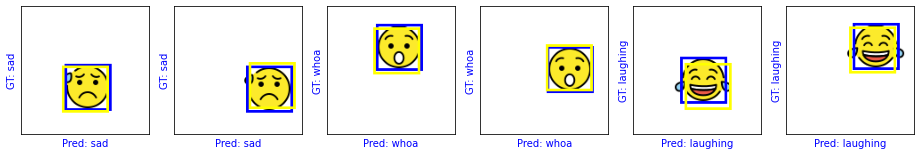

Epoch 21/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0014 - class_out_loss: 2.4444e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7579


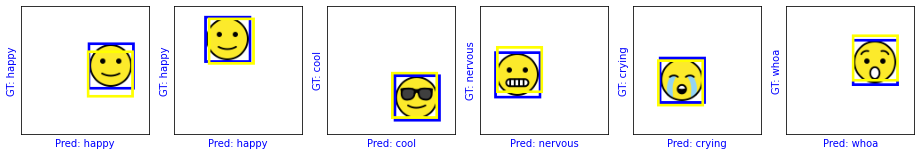

Epoch 22/50
500/500 [==============================] - 9s 19ms/step - loss: 0.0013 - class_out_loss: 2.1935e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7615


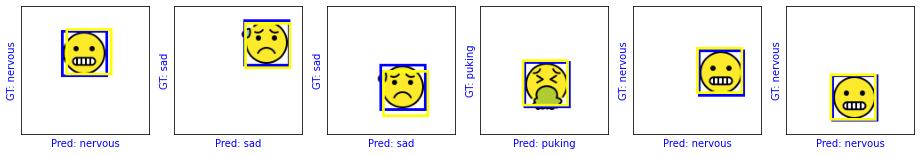

Epoch 23/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0014 - class_out_loss: 2.6553e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7596


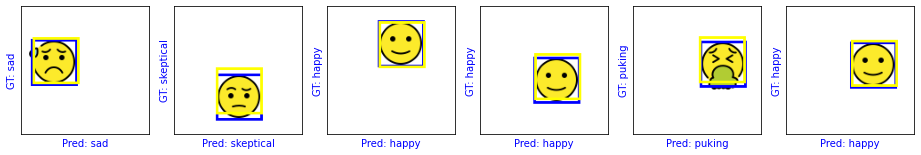

Epoch 24/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0013 - class_out_loss: 2.4441e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7655


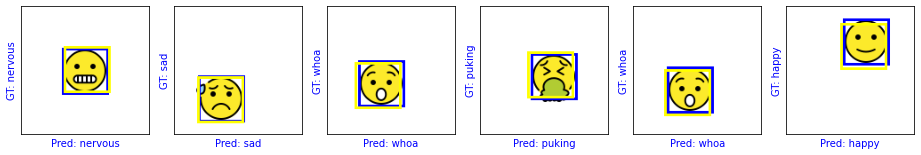

Epoch 25/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0013 - class_out_loss: 2.0401e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7663


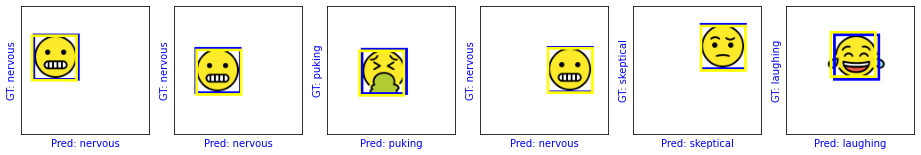

Epoch 26/50
500/500 [==============================] - 9s 19ms/step - loss: 0.0013 - class_out_loss: 2.7092e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7667


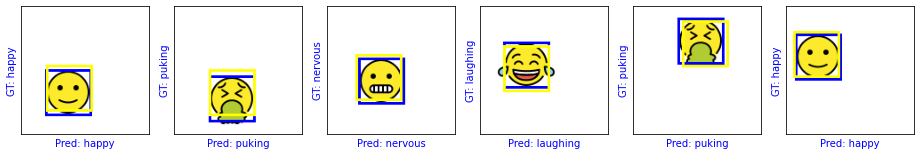

Epoch 27/50
500/500 [==============================] - 9s 19ms/step - loss: 0.0014 - class_out_loss: 2.7431e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7632


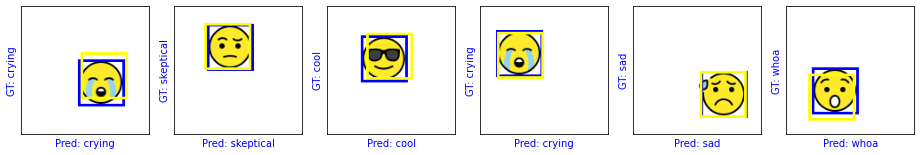

Epoch 28/50
500/500 [==============================] - 9s 19ms/step - loss: 0.0014 - class_out_loss: 2.5524e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7636


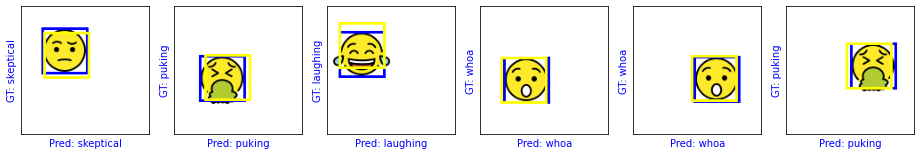

Epoch 29/50
500/500 [==============================] - 9s 19ms/step - loss: 0.0013 - class_out_loss: 2.2070e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7651


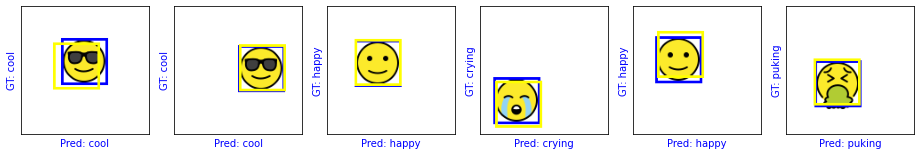

In [ ]:
def lr_schedule(epoch, lr):
  if (epoch + 1) % 5 == 0:
    lr *= 0.2
  return max(lr, 3e-7)

_ = model.fit(
    data_gen(),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
              ShowTestImages(),
              tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'),
              tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)